<a href="https://colab.research.google.com/github/ashtheflash1212/Drake-Lyrics/blob/main/Generate_Drake_Lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

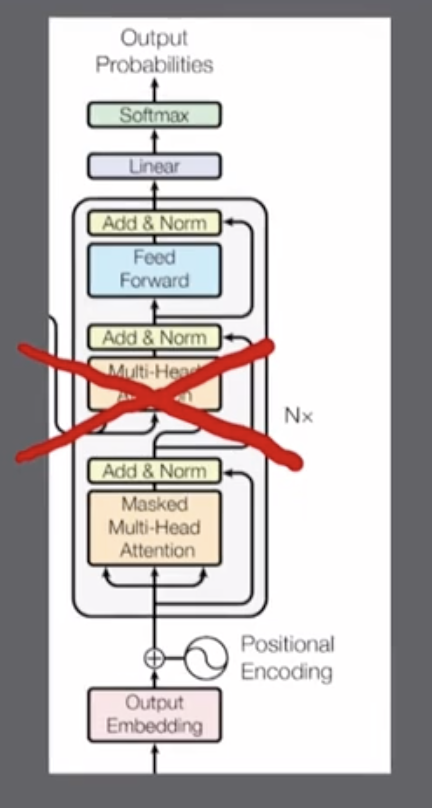

In [2]:
class GPT(nn.Module):

    class TransformerBlock(nn.Module):

        class MultiHeadedSelfAttention(nn.Module): #concat attention head instances, commmunication mechanism of token

            class SingleHeadAttention(nn.Module):
                def __init__(self, model_dim: int, head_size: int):
                    super().__init__()
                    #bias = False (no +b in linear layer)
                    self.key_layer = nn.Linear(model_dim, head_size, bias=False)
                    self.query_layer = nn.Linear(model_dim, head_size, bias=False)
                    self.value_layer = nn.Linear(model_dim, head_size, bias=False)

                def forward(self, embedded):
                    k = self.key_layer(embedded) # T x A tensor
                    q = self.query_layer(embedded) #T x A tensor
                    v = self.value_layer(embedded)
                    # @ does matrix multiplication
                    scores = q @ torch.transpose(k, 1, 2) # @ is the same as torch.matmul()
                    #transpose to do (B x T x A) x (B x A x T)
                    context_length, attention_dim = k.shape[1], k.shape[2]
                    scores = scores / (attention_dim ** 0.5) #scale factor, from 2017 paper, "Attention is all you Need", dk is attention di

                    lower_triangular = torch.tril(torch.ones(context_length, context_length)) # T x T tensor, premasking (turning future tokens into 0)
                    mask = (lower_triangular == 0).to(device)
                    scores = scores.masked_fill(mask, float('-inf')) # doesn't let tokens see future tokens
                    scores = nn.functional.softmax(scores, dim = 2) # B x T x T tensor, every row will have "probabilities" to sum to 1

                    return scores @ v #every token has a value (learned vector), what does token want to share (with other tokens)

            def __init__(self, model_dim: int, num_heads: int):
                super().__init__()
                self.attention_heads = nn.ModuleList() #like normal python list but only takes in modules/neural layers
                for i in range(num_heads):
                    self.attention_heads.append(self.SingleHeadAttention(model_dim, model_dim // num_heads))
                self.compute = nn.Linear(model_dim, model_dim)
                self.dropout = nn.Dropout(0.2)

            def forward(self, embedded):
                head_outputs = [] # B x T x Head_Size --> B x T x Attention_Dim
                for head in self.attention_heads:
                    head_outputs.append(head(embedded)) #every attention head takes embedded as input
                concatenated = torch.cat(head_outputs, dim = 2) # or dim= -1
                return self.dropout(self.compute(concatenated))

        class VanillaNeuralNetwork(nn.Module): #learning weights, computation

            def __init__(self, model_dim: int):
                super().__init__()
                self.first_linear_layer = nn.Linear(model_dim, model_dim * 4)
                self.relu = nn.ReLU()
                self.second_linear_layer = nn.Linear(model_dim * 4, model_dim)
                self.dropout = nn.Dropout(0.2) # using p = 0.2

            def forward(self, x):
                return self.dropout(self.second_linear_layer(self.relu(self.first_linear_layer(x))))

        def __init__(self, model_dim: int, num_heads: int):
            super().__init__()
            self.mhsa = self.MultiHeadedSelfAttention(model_dim, num_heads)
            self.vanilla_nn = self.VanillaNeuralNetwork(model_dim)
            self.layer_norm_one = nn.LayerNorm(model_dim) #takes B x T x D and does normalization on D (model_dim), normalization (uses mean, std dev)
            self.layer_norm_two = nn.LayerNorm(model_dim)

        def forward(self, embedded): #reminder: remember what skip connection does
            embedded = embedded + self.mhsa(self.layer_norm_one(embedded)) # skip connection, deals with proble of exploding/vanishing gradient
            embedded = embedded + self.vanilla_nn(self.layer_norm_two(embedded)) # another skip connection
            return embedded

    def __init__(self, vocab_size: int, context_length: int, model_dim: int, num_blocks: int, num_heads: int):
        # vocab_size - number of different tokens the model recognizes
        # context_length - how mmany tokens back the model can read
        # model_dim - feature dimensionality for embeddings and attention
        # num_blocks - number of repetitions of TransformerBlock
        # num_heads - number of self attnetion instances
        # context - previous tokens used to make prediction
        # Lookup Table - Rows: Vocab_size, Cols: model_dim
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim) #rows, cols
        self.pos_embedding = nn.Embedding(context_length, model_dim) # Write me a Poem, NOT...Poem me write a (need to learn embeddings for each token's position)
        self.transformer_blocks = nn.Sequential()
        for i in range(num_blocks): #needs to be neural network class, nn.Module()
            self.transformer_blocks.append(self.TransformerBlock(model_dim, num_heads)) #num_heads of self attention
        self.layer_norm_three = nn.LayerNorm(model_dim) #additional normalization # B x T x D --> B x T x D
        self.vocab_projection = nn.Linear(model_dim, vocab_size) #from B x T x D --> B x T x V (extracting predictions for the next token)

    def forward(self, context):
        embedded = self.token_embedding(context) # B x T x D
        context_length = context.shape[1]
        positions = torch.arange(context_length).to(device) #positional encoding
        embedded = embedded + self.pos_embedding(positions) #token embedds + positional embedds

        raw_output = self.vocab_projection(self.layer_norm_three(self.transformer_blocks(embedded)))
        # raw_output is batch by context_length by vocab_size

        return raw_output

generate() function:

In [3]:
def generate(model, new_chars: int, context, context_length: int, int_to_char: dict) -> str:
  # model - instance of GPT trained on a text file of all Drake songs
  # new_chars - the number of tokens GPT should generate
  # context - the intial input to the model, typically the newline character
  # context_length - the maximum number of tokens the model can read
  # int_to_char - a dictionary for decoding numbers back to characters
    res = []
    #context is B x T
    #len(context) = B
    #len(context.T) = T
    for i in range(new_chars):
        if len(context.T) > context_length:
            context = context[:, -context_length:] # trunctuating
        prediction = model(context) # B x T x Vocab_Size
        last_time_step = prediction[:, -1, :] # B x Vocab_Size, only care about last time step and not previous probabilities
        probabilities = nn.functional.softmax(last_time_step, dim = -1) # B x V, every row has probabilities that sum to 1
        next_char = torch.multinomial(probabilities, 1) #sampling, trying to select between good probabilities (to get unique results)
        context = torch.cat((context, next_char), dim = -1) # B x T --> B x T + 1
        res.append(int_to_char[next_char.item()])  # example - [10].item() --> 10
    return ''.join(res)

Download trained model:

In [4]:
!git clone https://github.com/gptandchill/drake-lyric-generator
%cd drake-lyric-generator

Cloning into 'drake-lyric-generator'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 16.53 MiB | 9.34 MiB/s, done.
/content/drake-lyric-generator


In [5]:
vocab_size = 104
context_length = 128
model_dim = 252
num_blocks = 6
num_heads = 6

model = GPT(vocab_size, context_length, model_dim, num_blocks, num_heads).to(device)
WEIGHT_PATH = 'weights.pt' # Adjust as necessary
model.load_state_dict(torch.load(WEIGHT_PATH))
model.eval()
new_chars = 5000
context = torch.zeros(1, 1, dtype = torch.int64).to(device)

int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

Drake Lyrics!

In [6]:
print(generate(model, new_chars,context,
               context_length,
               int_to_char))

Feat on my own man, I die and I know and understands porty
Die me if I'm fuckin' leg nice with I'm with in thours
I've worroted I went it, I wouldn't know
That's life outchin' on the cause to the life
Denny you like that you too sank AXAs on time
Hate, I got of girls, what you 'til to Drizzy All the sie lover
We feed in night up shows just down look your backjok it
They girl away like, momma's you after the time
So I'm showin', I'll bir–
That's the line, yeah? Thistin', yeah, ayeah
Tmoney servoin', everything time to me

[Verse 2]
When you know I see it when simile
With you don't love me, I been tryna ever come through
And we'll never get your diamonds, yeah I don't wanna want turn to while vicrar fishinate night
And gyed hot used to find 'em who to killow
And new I play it's all up of the concide
I got some goad, it's tookay, tootherfuck watchin', I gotta flips in the world
To took one different like time for then
And I'm lonely
So I can't still life around up you

[Verse 2: Drake]
Th